In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import logging
import os
%matplotlib inline

In [2]:
# Configurable Parameters
INPUT_DIR = '../examples/1/input/'
RESULTS_DIR = '../examples/1/results'
DATA_FILE = os.path.join(INPUT_DIR,'gps_data.csv')
OUT_DIR = os.path.join(RESULTS_DIR,'gps_out/')

In [3]:
class GpsDataProcessor(object):
    def __init__(self, data_file, slope_threshold=.00005, time_threshold=50, merge_threshold=2, normalize=True):
        self.sparse_data = np.genfromtxt(data_file, delimiter=',')
        self.sparse_data = self.sparse_data[:, 0:3]
        self.slope_threshold = slope_threshold
        self.time_threshold = time_threshold
        self.merge_threshold = merge_threshold
        self.normalize = normalize
        self.num_columns = 3 # timestamp latitude longitude
        self.ts = 0  # Timestamp
        self.lat = 1 # Latitude Column
        self.lg = 2  # Longitude Column

    def plot_map(self):
        pass

    def plot_graph(self, rest_intervals):
        if self.normalize:
            first_ts = int(self.data[0, self.ts])
        else:
            first_ts = 0
        plt.plot((self.data[:, self.ts] - first_ts), self.data[:, self.lat], label='Latitude')
        plt.plot((self.data[:, self.ts] - first_ts), self.data[:, self.lg], label='Longitude')
        
        for rest_interval in rest_intervals:
            plt.axvline(x=rest_interval[0], color='y')
            plt.axvline(x=rest_interval[1], color='r')
        plt.legend()
    
    def is_slope_stationary(self, prev_sample, cur_sample):
        return ((abs(cur_sample[self.lat] - prev_sample[self.lat]) < self.slope_threshold) and 
                (abs(cur_sample[self.lg] - prev_sample[self.lg]) < self.slope_threshold))

    def slope_filter(self):
        rest_intervals = []
        self.data[:, self.ts] = self.data[:, self.ts] - self.data[0, self.ts]
        prev_sample = self.data[0]
        start_timestamp = None
        for cur_sample in self.data[1:]:
            if self.is_slope_stationary(prev_sample, cur_sample):
                # Detected start of new rest interval
                if start_timestamp is None:
                    start_timestamp = prev_sample[self.ts]
                    end_timestamp = cur_sample[self.ts]
                # Update end of current rest interval
                else:
                    end_timestamp = cur_sample[self.ts]
            else:
                # Detected end of previous rest interval
                if start_timestamp is not None:
                    rest_intervals.append((start_timestamp, end_timestamp))
                    start_timestamp = None
                    end_timestamp = None
            prev_sample = cur_sample
        return rest_intervals
    
    def time_filter(self, intervals):
        filtered_intervals = []
        for interval in intervals:
            if (interval[1] - interval[0]) > self.time_threshold:
                filtered_intervals.append(interval)
        return filtered_intervals
    
    @staticmethod
    def distance(interval1, interval2):
        # Non overlapping intervals
        return max(interval2[0] - interval1[1], interval1[0] - interval2[1], 0)
    
    # Assumes that intervals are sorted by start time
    def merge_small_intervals(self, intervals):
        merged_intervals = []
        prev_interval = intervals[0]
        start, end = prev_interval
        for cur_interval in intervals[1:]:
            if self.distance(prev_interval, cur_interval) < self.time_threshold:
                end = cur_interval[1]
            else:
                merged_intervals.append((start, end))
                start, end = None, None
                # Append last interval if it is not overalapping with previous ones.
                if cur_interval == intervals[-1]:
                    merged_intervals.append(cur_interval)
            # Update intervals        
            prev_interval = cur_interval
            if start is None:
                start, end = prev_interval
        if merged_intervals == []:
            merged_intervals.append([start,end])
        return merged_intervals
            
    def fill_data(self):
        num_timestamps = int(self.sparse_data[-1][self.ts]) - int(self.sparse_data[0][self.ts]) + 1
        self.data = np.zeros((num_timestamps, self.num_columns))
        first_timestamp = self.sparse_data[0][self.ts]
        
        prev_sample = self.sparse_data[0]
        index = 0
        for cur_sample in self.sparse_data[1:]:
            for timestamp in range(int(prev_sample[self.ts]), int(cur_sample[self.ts])):
                sample = (timestamp, prev_sample[self.lat], prev_sample[self.lg])
                self.data[index] = sample
                index += 1
            prev_sample = cur_sample
        self.data[index] = self.sparse_data[-1]
        
        if self.normalize:
            lat_mean = np.mean(self.data[:, self.lat])
            long_mean = np.mean(self.data[:, self.lg])
            self.data[:, self.lat] = (self.data[:, self.lat] - lat_mean)
            self.data[:, self.lg] = (self.data[:, self.lg] - long_mean)

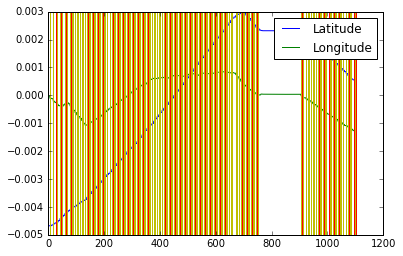

In [4]:
if __name__ == "__main__":
    gps_motion_detector = GpsDataProcessor(DATA_FILE)
    gps_motion_detector.fill_data()
    rest_intervals = gps_motion_detector.slope_filter()
    gps_motion_detector.plot_graph(rest_intervals)

[(750.0, 905.0)]


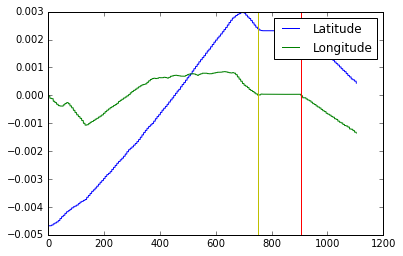

In [5]:
rest_intervals = gps_motion_detector.time_filter(rest_intervals)
print rest_intervals
gps_motion_detector.plot_graph(rest_intervals)

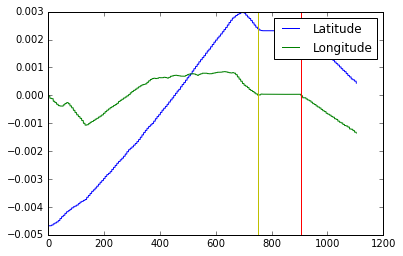

In [6]:
rest_intervals = gps_motion_detector.merge_small_intervals(rest_intervals)
np.save(os.path.join(OUT_DIR,'gps_out'),np.asarray(rest_intervals))
gps_motion_detector.plot_graph(rest_intervals)

In [7]:
rest_intervals

[[750.0, 905.0]]